In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import time
import re

from bs4 import BeautifulSoup
import requests

In [9]:
url = 'https://www.sports-reference.com/cbb/postseason/men/2024-ncaa.html'
response = requests.get(url)

if response.status_code == 200:
    soup = BeautifulSoup(response.text, 'html.parser')
else:
    print(f"Failed to retrieve content, status code: {response.status_code}")

# List of 64 teams in the playoffs
a_tags = soup.find_all('a')[67:131]

# Parse HTML
base_url = "https://www.sports-reference.com"
urls = [base_url + tag['href'] for tag in a_tags if 'href' in tag.attrs]

df_list = []
counter = 0

for team in urls:
    print('///// Currently parsing tables for : {} /////'.format(team.split('/')[5].upper()))
    print('\n')
    year = int(urls[0].split('/')[-1].split('.')[0])
    lookback_years = (lambda x: [x - i for i in range(15)])(year)


    for yr in lookback_years:

        new_team_url = (lambda url, year: re.sub(r'(\d{4})(\.html)$', str(year) + r'\2', url))(team, yr)
        print("Fetching data from {} ... ".format(yr))
        res = requests.get(url=new_team_url)
        time.sleep(5)
           
        if counter == 15:
            print('Reaching requests limit, resetting counter')
            time.sleep(65)
            counter = 0

        if res.status_code == 200:
            soup = BeautifulSoup(res.text, 'html.parser')
            table_container = soup.select_one('#div_per_game')
            per_game_table = table_container.find('table', id='per_game') if table_container else None
            
            if per_game_table:
                print('Successfully fetched {} table'.format(yr))
                data = pd.read_html(team)[5]
                data['Year'] = str(yr)
                df_list.append(data)
                counter += 1

            else:
                print("Failed to fetch data from {}".format(new_team_url))

    print('\n')


final_df = pd.concat(df_list, ignore_index=True)

///// Currently parsing tables for : CONNECTICUT /////


Fetching data from 2024 ... 
Successfully fetched 2024 table
Fetching data from 2023 ... 
Successfully fetched 2023 table
Fetching data from 2022 ... 
Successfully fetched 2022 table
Fetching data from 2021 ... 
Successfully fetched 2021 table
Fetching data from 2020 ... 
Successfully fetched 2020 table
Fetching data from 2019 ... 
Successfully fetched 2019 table
Fetching data from 2018 ... 
Successfully fetched 2018 table
Fetching data from 2017 ... 
Successfully fetched 2017 table
Fetching data from 2016 ... 
Successfully fetched 2016 table
Fetching data from 2015 ... 
Successfully fetched 2015 table
Fetching data from 2014 ... 
Successfully fetched 2014 table
Fetching data from 2013 ... 
Successfully fetched 2013 table
Fetching data from 2012 ... 
Successfully fetched 2012 table
Fetching data from 2011 ... 
Successfully fetched 2011 table
Fetching data from 2010 ... 
Successfully fetched 2010 table


///// Currently parsing ta

### Analysis

In [22]:
df = pd.read_csv('per_game_data.csv').drop('Unnamed: 0', axis=1)
df = df.iloc[:, 2:26]

In [23]:
df

,G,GS,MP,FG,FGA,FG%,2P,2PA,2P%,3P,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,34,34,33.1,4.5,11.0,0.412,2.8,5.6,0.497,1.8,...,0.804,1.4,5.6,7.0,6.0,1.0,0.4,2.6,1.8,15.2
1,34,34,33.0,4.9,10.0,0.488,2.3,4.2,0.549,2.6,...,0.913,0.9,3.5,4.5,3.6,1.4,0.2,1.1,2.2,14.5
2,33,33,31.5,5.1,10.2,0.501,2.9,4.6,0.632,2.2,...,0.889,1.3,3.7,5.0,1.4,0.9,0.8,1.0,1.9,13.9
3,29,27,21.9,5.0,7.9,0.638,5.0,7.7,0.646,0.1,...,0.570,2.6,4.6,7.2,1.5,0.4,2.3,0.8,2.0,12.5
4,28,24,26.8,3.9,8.3,0.468,3.3,6.3,0.528,0.6,...,0.756,1.6,2.9,4.5,2.9,0.9,0.6,1.5,2.3,10.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12373,19,0,5.7,0.8,2.1,0.410,0.8,1.4,0.593,0.0,...,0.867,0.6,1.1,1.7,0.8,0.2,0.1,0.5,0.5,2.4
12374,18,0,3.8,0.4,0.8,0.467,0.3,0.5,0.667,0.1,...,0.667,0.1,0.1,0.2,0.6,0.4,0.0,0.2,0.3,0.9
12375,8,0,1.4,0.1,0.6,0.200,0.0,0.0,NaN,0.1,...,NaN,0.1,0.0,0.1,0.0,0.1,0.0,0.0,0.0,0.4
12376,10,0,1.5,0.2,0.4,0.500,0.2,0.4,0.500,0.0,...,0.000,0.1,0.3,0.4,0.0,0.0,0.0,0.0,0.6,0.4


In [24]:
correlation_matrix = df.corr()
target_correlation = correlation_matrix['PTS'].drop('PTS')  # Exclude self-correlation
top_correlated_features = target_correlation.abs().sort_values(ascending=False).head(20)
print(top_correlated_features)

FG     0.989866
FGA    0.980973
MP     0.920118
2PA    0.910918
FT     0.910708
FTA    0.889089
2P     0.882998
TOV    0.847132
GS     0.834106
DRB    0.820472
TRB    0.767487
STL    0.725164
3PA    0.711356
3P     0.710615
PF     0.709519
AST    0.694419
G      0.647062
ORB    0.528677
BLK    0.439554
FT%    0.349618
Name: PTS, dtype: float64


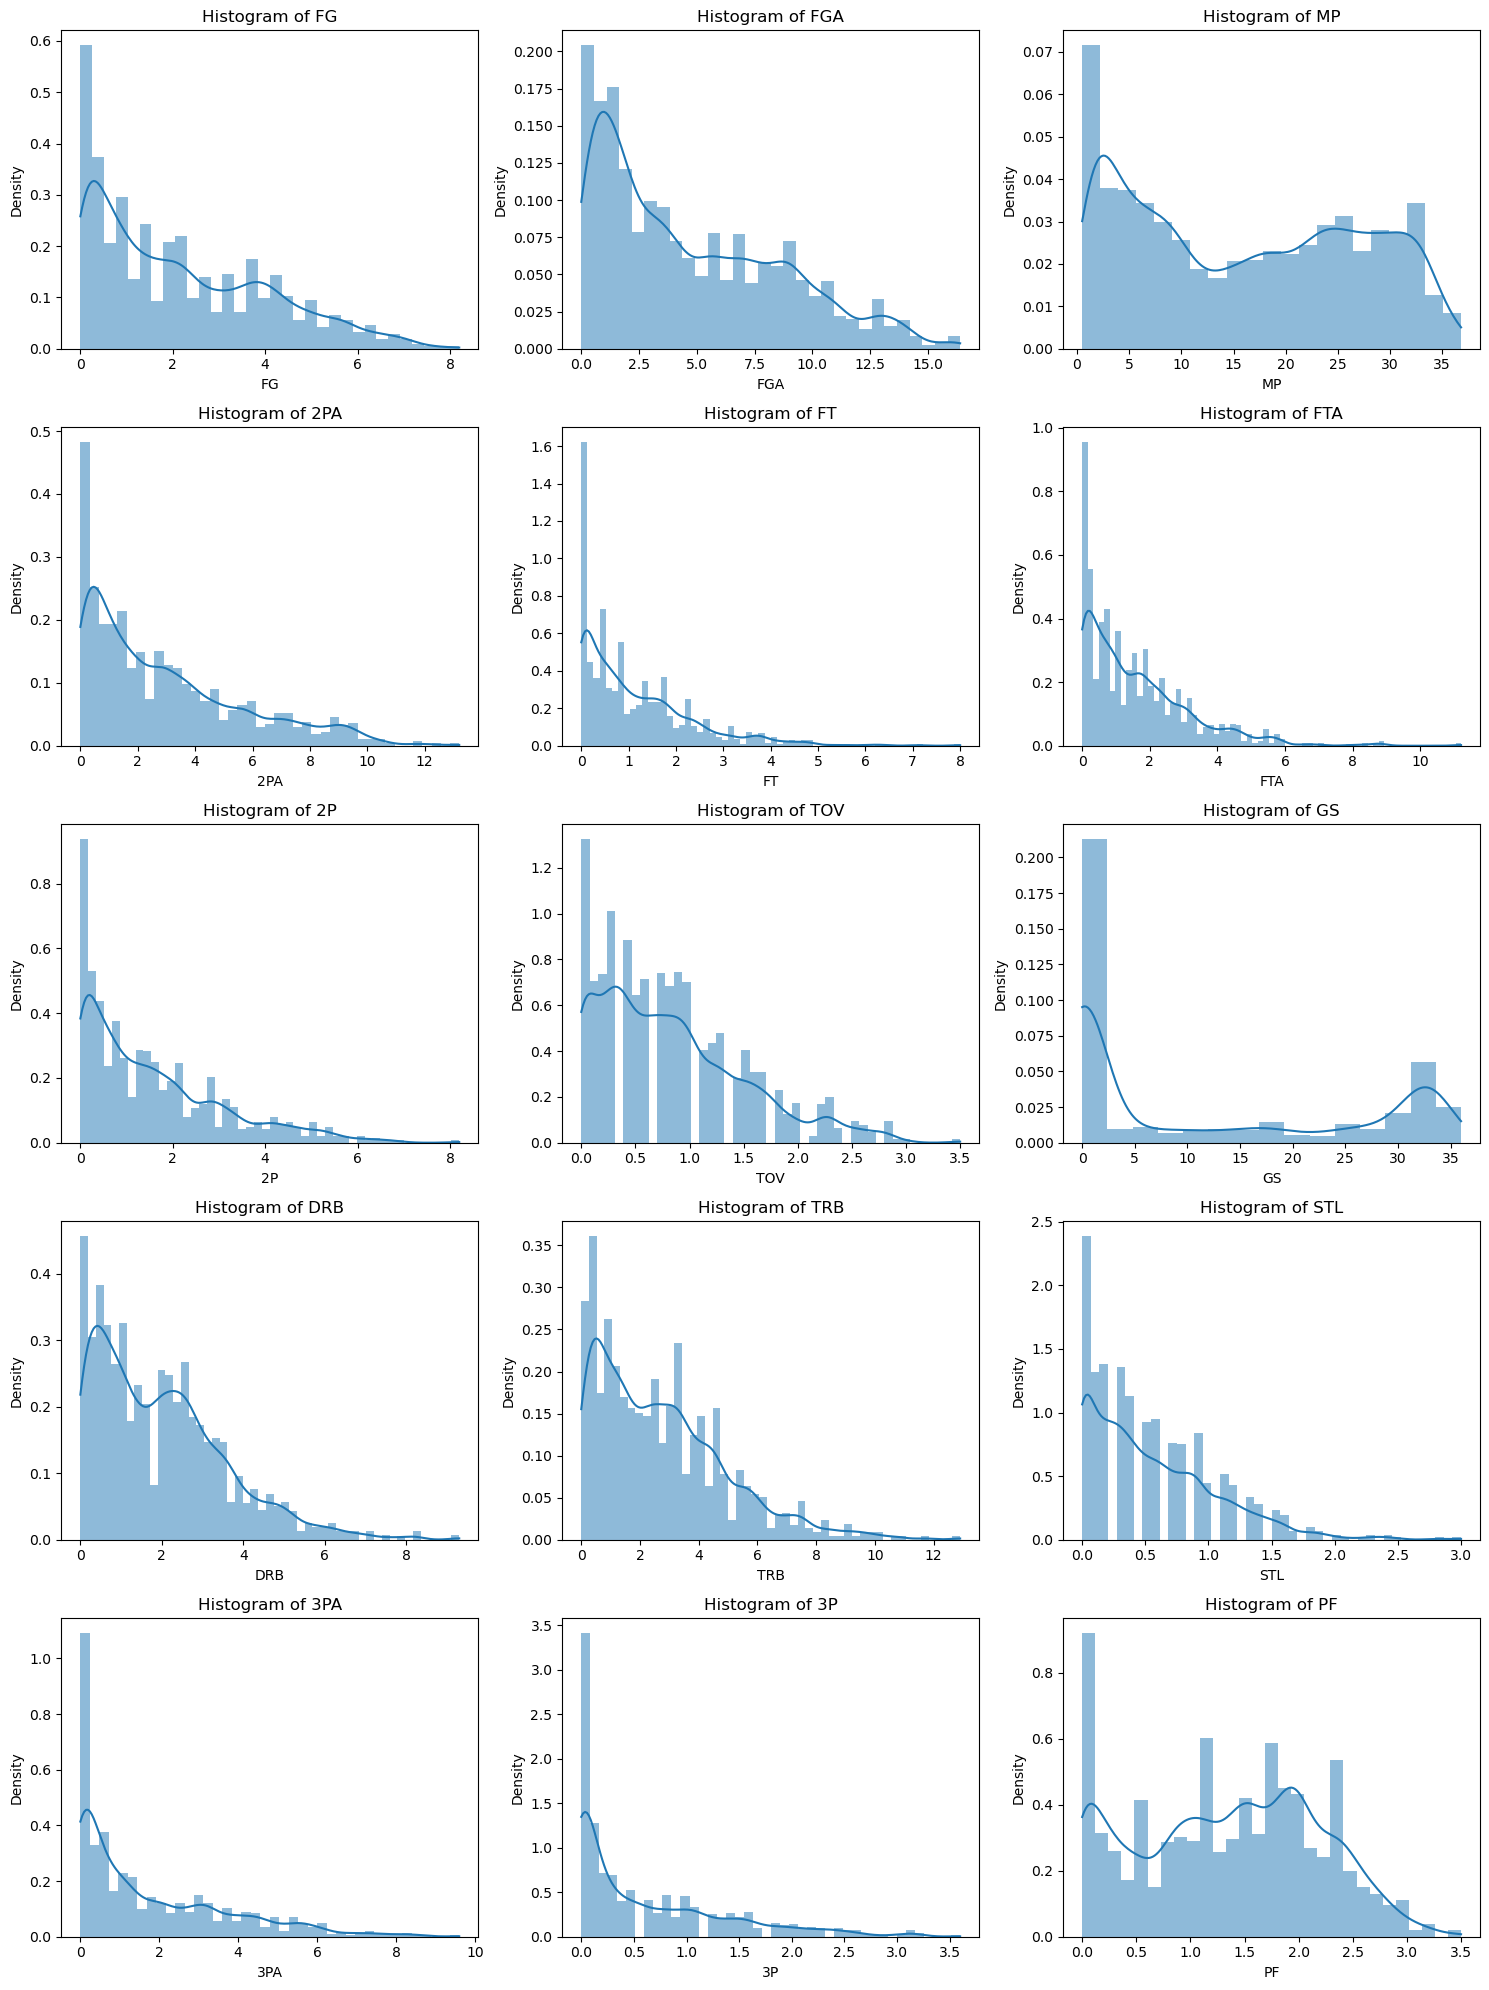

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

top_15_features = top_correlated_features.head(15).index.tolist()

# Setting up the figure and axes for a 5x3 subplot grid
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 20))
fig.tight_layout(pad=5.0)

# Iterating over each feature and its respective position in the grid
for i, feature in enumerate(top_15_features):
    row, col = divmod(i, 3)
    sns.histplot(df[feature], kde=True, stat="density", linewidth=0, ax=axes[row, col])
    axes[row, col].set_title(f'Histogram of {feature}')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Density')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()


<Axes: xlabel='PTS', ylabel='Density'>

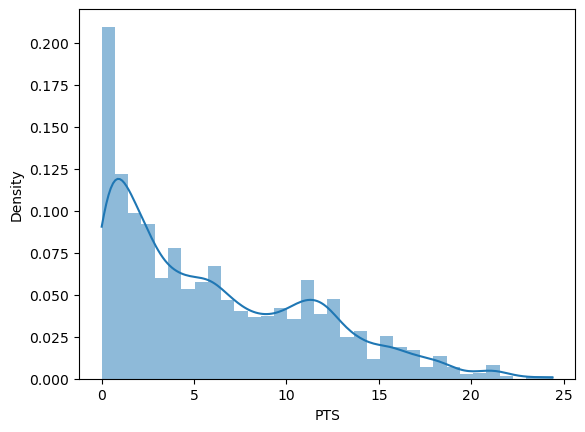

In [28]:
sns.histplot(df['PTS'], kde=True, stat="density", linewidth=0)


In [38]:
X = df[top_15_features]
y = df['PTS']


In [58]:
X = df[top_15_features]
y = df['PTS']

with pm.Model() as bayesian_linear_regression:

    # Priors for the regression coefficients
    beta_FG = pm.LogNormal('beta_FG', mu=0, sigma=1)
    beta_FGA = pm.LogNormal('beta_FGA', mu=0, sigma=1)
    beta_MP = pm.Exponential('beta_MP', lam=1)
    beta_2PA = pm.LogNormal('beta_2PA', mu=0, sigma=1)
    beta_FT = pm.LogNormal('beta_FT', mu=0, sigma=1)
    beta_FTA = pm.LogNormal('beta_FTA', mu=0, sigma=1)
    beta_2P = pm.LogNormal('beta_2P', mu=0, sigma=1)
    beta_TOV = pm.LogNormal('beta_TOV', mu=0, sigma=1)
    beta_GS = pm.Exponential('beta_GS', 1)
    beta_DRB =  pm.Normal('beta_DRB', mu=0, sigma=1)
    beta_TRB = pm.Normal('beta_TRB', mu=0, sigma=1)
    beta_STL = pm.Exponential('beta_STL', 1)
    beta_3PA = pm.Normal('beta_3PA', mu=0, sigma=1)
    beta_3P = pm.Normal('beta_3P', mu=0, sigma=1)
    beta_PF =  pm.Normal('beta_PF', mu=0, sigma=1)

    beta_vector = pm.math.stack([beta_FG, beta_FGA, beta_MP, beta_2PA, beta_FT, beta_FTA, beta_2P, beta_TOV, beta_GS, beta_DRB, beta_TRB, beta_STL, beta_3PA, beta_3P, beta_PF])

    # Model error prior
    sigma = pm.HalfCauchy('sigma', beta=10)

    # Expected value (linear model)
    mu = pm.math.dot(X, beta_vector)

    # Likelihood of observations
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

    # 3000 posterior samples using NUTS sampling
    trace = pm.sample(3000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_FG, beta_FGA, beta_MP, beta_2PA, beta_FT, beta_FTA, beta_2P, beta_TOV, beta_GS, beta_DRB, beta_TRB, beta_STL, beta_3PA, beta_3P, beta_PF, sigma]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 885 seconds.


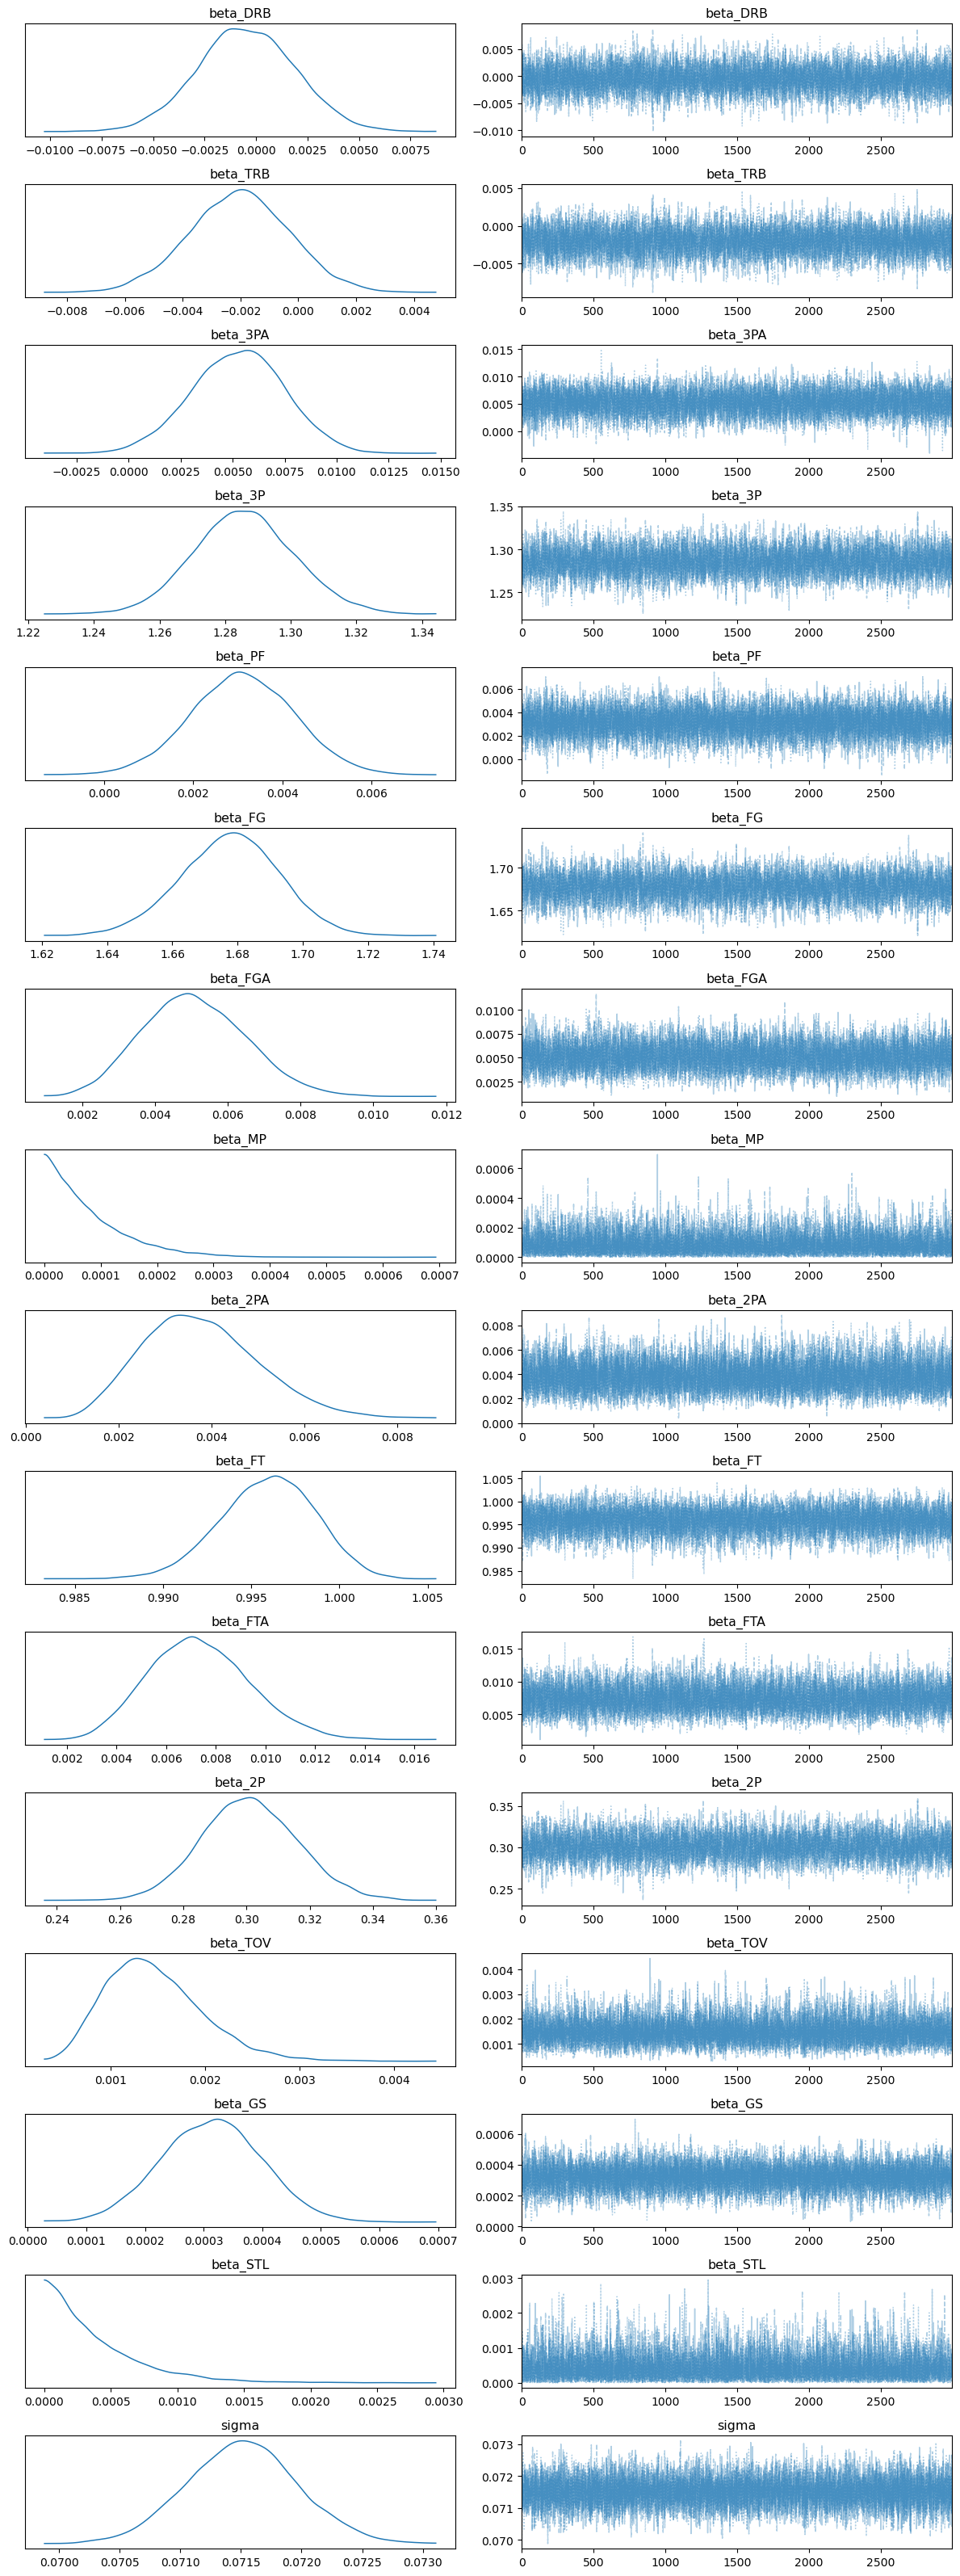

In [59]:
import arviz as az
az.plot_trace(trace, combined=True);
plt.tight_layout()